In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stressless-unix/data_unix.csv
/kaggle/input/data-class/data.csv
/kaggle/input/stressless-date/data(1).csv


In [3]:
import pandas as pd

df = pd.read_csv('/kaggle/input/data-class/data.csv')
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,2024-01-24 10:01:09,Anh,171.1,Chill,8.0,0.457849
1,1706086870,2024-01-24 10:01:10,Anh,171.0,Chill,8.0,0.458344
2,1706086872,2024-01-24 10:01:12,Anh,170.9,Chill,8.0,0.458838
3,1706086873,2024-01-24 10:01:13,Anh,170.8,Chill,8.0,0.459333
4,1706086874,2024-01-24 10:01:14,Anh,170.7,Chill,8.0,0.459827


In [4]:
import time
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].dt.hour
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,10,Anh,171.1,Chill,8.0,0.457849
1,1706086870,10,Anh,171.0,Chill,8.0,0.458344
2,1706086872,10,Anh,170.9,Chill,8.0,0.458838
3,1706086873,10,Anh,170.8,Chill,8.0,0.459333
4,1706086874,10,Anh,170.7,Chill,8.0,0.459827


In [5]:
df.dtypes

unix_time           int64
datetime            int32
person             object
value             float64
activity           object
sleep_duration    float64
stress_lvl        float64
dtype: object

In [6]:
df['stress_lvl'] = df['stress_lvl'].round(0)
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,10,Anh,171.1,Chill,8.0,0.0
1,1706086870,10,Anh,171.0,Chill,8.0,0.0
2,1706086872,10,Anh,170.9,Chill,8.0,0.0
3,1706086873,10,Anh,170.8,Chill,8.0,0.0
4,1706086874,10,Anh,170.7,Chill,8.0,0.0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer

X = df.copy()
X.drop(columns=['stress_lvl', 'unix_time', 'person'], inplace=True)
y = df.stress_lvl

categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime','value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler(),
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = to_categorical(y_train, num_classes=6)
y_valid = to_categorical(y_valid, num_classes=6)
input_shape = [X_train.shape[1]]

scaler = preprocessor.named_transformers_['num']
num_means = scaler.named_steps['standardscaler'].mean_
num_std = scaler.named_steps['standardscaler'].scale_

print("Mean of numerical columns:", num_means)
print("Standard deviation of numerical columns:", num_std)

2024-03-01 08:50:22.141657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 08:50:22.141859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 08:50:22.336624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Mean of numerical columns: [ 14.55414512 105.96825141   7.42014927]
Standard deviation of numerical columns: [ 3.84879331 30.30182165  1.1645083 ]


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=input_shape),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=6, activation='sigmoid')
])

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[keras.metrics.CategoricalAccuracy()]
)

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)


Epoch 1/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.4219 - loss: 1.3251 - val_categorical_accuracy: 0.5458 - val_loss: 1.0350
Epoch 2/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.5543 - loss: 1.0092 - val_categorical_accuracy: 0.5829 - val_loss: 0.9527
Epoch 3/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - categorical_accuracy: 0.5904 - loss: 0.9411 - val_categorical_accuracy: 0.6073 - val_loss: 0.9112
Epoch 4/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.6153 - loss: 0.9024 - val_categorical_accuracy: 0.6258 - val_loss: 0.8793
Epoch 5/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.6315 - loss: 0.8708 - val_categorical_accuracy: 0.6370 - val_loss: 0.8580
Epoch 6/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.6453 - loss: 0.8497 - val_categorical_accuracy: 0.6523 - val_loss: 0.8356
Epoch 7/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_a

<Axes: title={'center': 'Training and Validation Accuracy'}>

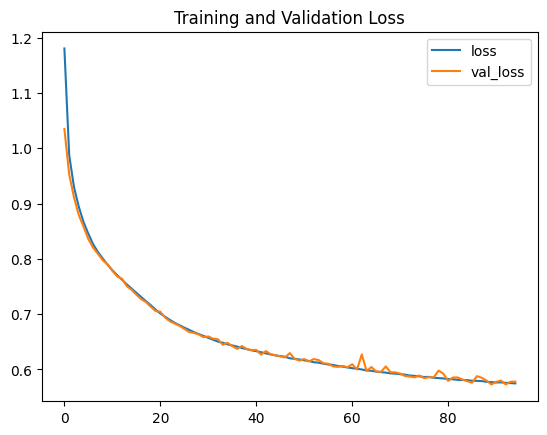

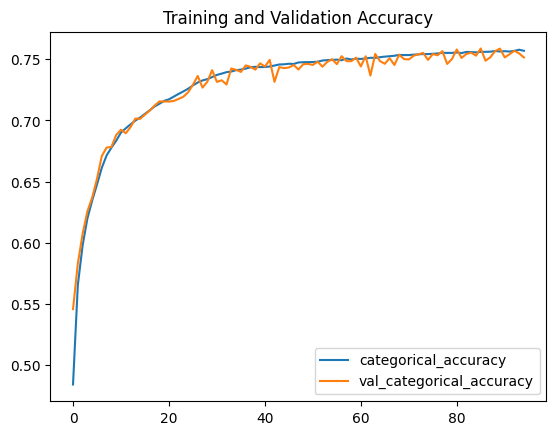

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Training and Validation Loss")
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(title="Training and Validation Accuracy")

In [17]:
data = {
    "datetime": [10.0, 19.0, 17.0, 20.0, 19.0],
    "value": [80, 80, 80, 105, 120],
    "activity": ['Work', 'Chill', 'Hobby', 'Uni', 'Social'],
    "sleep_duration": [8.0, 8.0, 8.0, 8.0, 8.0]
}

test_df = pd.DataFrame(data)

test_df['datetime'] = test_df['datetime'].astype('float64')
test_df['sleep_duration'] = test_df['sleep_duration'].astype('float64')
test_df.dtypes

datetime          float64
value               int64
activity           object
sleep_duration    float64
dtype: object

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# Define the mean and standard deviation values
mean_numerical = [14.55020289, 105.930505, 7.42024268]
std_numerical = [3.85559805, 30.29517411, 1.16461952]

# Define the categorical and numerical transformers
categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime', 'value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler()
)

# Set the mean and standard deviation values for StandardScaler
numerical_transformer.named_steps['standardscaler'].mean_ = mean_numerical
numerical_transformer.named_steps['standardscaler'].scale_ = std_numerical

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to test_df
test_df_pre = preprocessor.fit_transform(test_df)

print(test_df_pre)


[[-1.92668659 -0.78250805  0.          0.          0.          0.
   0.          1.        ]
 [ 0.55048188 -0.78250805  0.          1.          0.          0.
   0.          0.        ]
 [ 0.         -0.78250805  0.          0.          1.          0.
   0.          0.        ]
 [ 0.82572282  0.72231512  0.          0.          0.          0.
   1.          0.        ]
 [ 0.55048188  1.62520902  0.          0.          0.          1.
   0.          0.        ]]


In [19]:
prediction = model.predict(test_df_pre)
#prediction

print(prediction.argmax(axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[1 3 2 3 1]


In [20]:
predicted_labels = prediction.argmax(axis=1)
print(predicted_labels)

[1 3 2 3 1]


In [21]:
for i, pred_probs in enumerate(prediction):
    print(f"Sample {i + 1} predicted probabilities:")
    for j, prob in enumerate(pred_probs):
        formatted_prob = "{:.2%}".format(prob)  # Format the probability as percentage with 2 decimal places
        print(f"Class {j}: {formatted_prob}")
    print()

Sample 1 predicted probabilities:
Class 0: 97.77%
Class 1: 99.72%
Class 2: 6.42%
Class 3: 0.16%
Class 4: 0.00%
Class 5: 0.00%

Sample 2 predicted probabilities:
Class 0: 61.37%
Class 1: 87.86%
Class 2: 94.34%
Class 3: 96.73%
Class 4: 32.49%
Class 5: 7.96%

Sample 3 predicted probabilities:
Class 0: 99.30%
Class 1: 58.27%
Class 2: 99.99%
Class 3: 22.55%
Class 4: 0.00%
Class 5: 0.00%

Sample 4 predicted probabilities:
Class 0: 30.46%
Class 1: 94.88%
Class 2: 99.31%
Class 3: 99.66%
Class 4: 99.63%
Class 5: 0.00%

Sample 5 predicted probabilities:
Class 0: 94.18%
Class 1: 99.89%
Class 2: 99.73%
Class 3: 97.35%
Class 4: 0.00%
Class 5: 0.00%



In [23]:

data = {
    "datetime": [9.0, 17.0, 17.0, 20.0, 19.0],
    "value": [70, 80, 80, 105, 120],
    "activity": ['Work', 'Chill', 'Hobby', 'Uni', 'Social'],
    "sleep_duration": [8.0, 6.0, 7.5, 5.0, 8.0]
}


test_df = pd.DataFrame(data)

test_df['datetime'] = test_df['datetime'].astype('float64')
test_df['sleep_duration'] = test_df['sleep_duration'].astype('float64')
test_df.dtypes
df = pd.DataFrame(data)

# Define the mean and standard deviation values
mean_numerical = [14.55020289, 105.930505, 7.42024268]
std_numerical = [3.85559805, 30.29517411, 1.16461952]

categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime', 'value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler(),
)

# Set the mean and standard deviation values for StandardScaler
numerical_transformer.named_steps['standardscaler'].mean_ = mean_numerical
numerical_transformer.named_steps['standardscaler'].scale_ = std_numerical

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

test_df_pre = preprocessor.fit_transform(test_df)

prediction = model.predict(test_df_pre)

predicted_stress = pd.DataFrame(prediction.argmax(axis=1), columns=['predicted_stress_lvl'])
predicted_stress.index = test_df.index
df_corr = pd.concat([test_df, predicted_stress], axis=1)

df_corr = df_corr.drop(columns=['activity'], inplace=False)

correlation_matrix = df_corr.corr()

print("Test data + Predicted Stress Level:")
print(df_corr.head())
print("\nKorrelationsmatrix:")
print(correlation_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test data + Predicted Stress Level:
   datetime  value  sleep_duration  predicted_stress_lvl
0       9.0     70             8.0                     0
1      17.0     80             6.0                     0
2      17.0     80             7.5                     2
3      20.0    105             5.0                     0
4      19.0    120             8.0                     1

Korrelationsmatrix:
                      datetime     value  sleep_duration  predicted_stress_lvl
datetime              1.000000  0.745181       -0.528603              0.244963
value                 0.745181  1.000000       -0.130298              0.094354
sleep_duration       -0.528603 -0.130298        1.000000              0.479167
predicted_stress_lvl  0.244963  0.094354        0.479167              1.000000


5766/5766 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


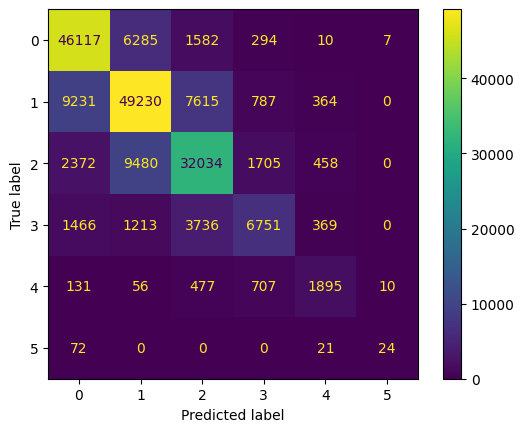

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predicting classes for validation data
y_pred = np.argmax(model.predict(X_valid), axis=1)

y_true = np.argmax(y_valid, axis=1)

cm = confusion_matrix(y_true, y_pred)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(6))
disp.plot()

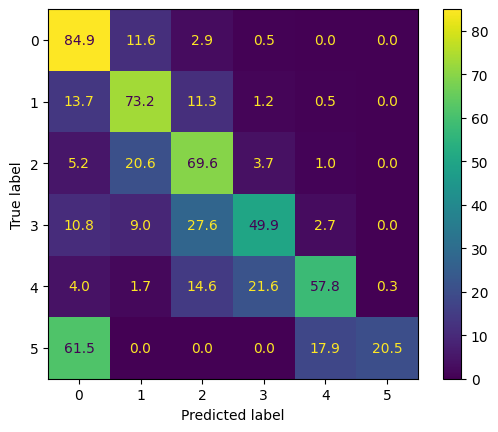

In [25]:
# normalized confusion matrix 
# where each value represents the percentage of samples for the corresponding class
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# display confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=np.arange(6))
disp2.plot(values_format='.1f')

In [26]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "tfjsmodel")

ModuleNotFoundError: No module named 'tensorflowjs'